# Classification Algorithm for Objects of Interest in the Kepler Objects of Interest Database

In [31]:
import itertools
import scipy
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from tensorflow.keras import layers


plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['font.size'] = (20)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = False 
plt.rcParams['text.color'] = 'black'

In [2]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.RdBu):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'], linewidth=8, c='black')
    plt.plot(history.history['val_accuracy'], linewidth=8, c='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'], linewidth=8, c='black')
    plt.plot(history.history['val_loss'], linewidth=8, c='red')
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

## About the Dataset

From Nasa, [this dataset](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=koi) has 9564 rows of objects and 50 columns, [explained here](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html), of information about the objects. They are classified as either candidate, false positive, or confirmed. 

In [3]:
#import the data
data = pd.read_csv('koi_111523.csv', skiprows=92)

In [4]:
#drop any columns that are completely nan
columns = data.columns.to_list()
d = []
for column in columns:
    if data[column].isnull().sum() == len(data[column]):
        data = data.drop([column], axis=1)
        d.append(column) 
print('Columns dropped: ',d)

Columns dropped:  ['koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_eccen_err1', 'koi_eccen_err2', 'koi_longp', 'koi_longp_err1', 'koi_longp_err2', 'koi_duration_err1', 'koi_duration_err2', 'koi_ingress', 'koi_ingress_err1', 'koi_ingress_err2', 'koi_depth_err1', 'koi_depth_err2', 'koi_srho', 'koi_srho_err1', 'koi_srho_err2', 'koi_sma_err1', 'koi_sma_err2', 'koi_incl_err1', 'koi_incl_err2', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_num_transits', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_smet', 'koi_smet_err1', 'koi_smet_err2']


In [5]:
#view the columns and their data types & how much of the column is available (non-null)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 51 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   kepid             3865 non-null   int64  
 1   kepoi_name        3865 non-null   object 
 2   kepler_name       2317 non-null   object 
 3   koi_disposition   3865 non-null   object 
 4   koi_pdisposition  3865 non-null   object 
 5   koi_period        3865 non-null   float64
 6   koi_period_err1   3845 non-null   float64
 7   koi_period_err2   3845 non-null   float64
 8   koi_time0bk       3865 non-null   float64
 9   koi_time0bk_err1  3845 non-null   float64
 10  koi_time0bk_err2  3845 non-null   float64
 11  koi_time0         3865 non-null   float64
 12  koi_time0_err1    3845 non-null   float64
 13  koi_time0_err2    3845 non-null   float64
 14  koi_eccen         3865 non-null   int64  
 15  koi_impact        3865 non-null   float64
 16  koi_impact_err1   3865 non-null   float64


In [6]:
#we will split the candidate objects from the confirmed/false positives - maybe later make a prediction of the candidates
data_cand = data[data['koi_disposition'] == 'CANDIDATE']
data_conf = data[(data['koi_disposition'] != 'CANDIDATE') & (data['koi_disposition'] != 'NOT DISPOSITIONED')]

In [7]:
data_conf['koi_disposition'] = data_conf['koi_disposition'].map({'CONFIRMED': 1, 'FALSE POSITIVE': 0})

/var/folders/9p/hzj7ch392lg17l9_qd41j1j00000gn/T/ipykernel_27440/3215670914.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_conf['koi_disposition'] = data_conf['koi_disposition'].map({'CONFIRMED': 1, 'FALSE POSITIVE': 0})


(0.0, 2500.0)

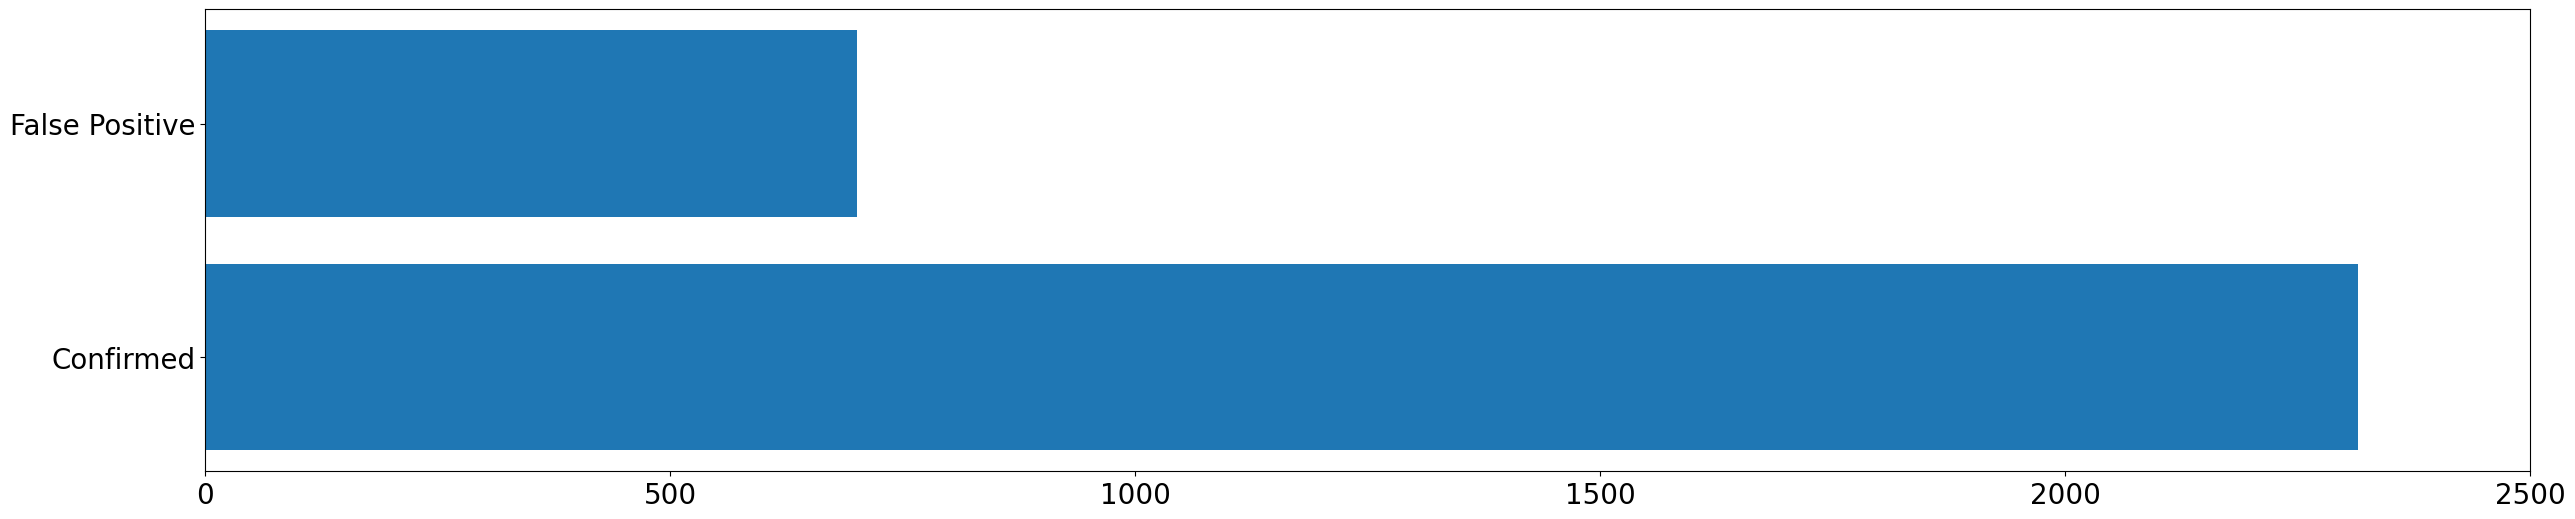

In [8]:
fig, ax = plt.subplots()
ax.barh([0,1], [data_conf['koi_disposition'].value_counts()[1],data_conf['koi_disposition'].value_counts()[0]], align='center')
ax.set_yticks(ticks=[0,1], labels=['Confirmed', 'False Positive'])
ax.set_xlim(0,2500)

In [9]:
#theres nearly 3x the confirmed as there are false positive, so this will likely cause a bias in our model
#we can resample so that the imbalance is less severe
confirmed = data_conf[data_conf['koi_disposition'] == 1]
false_positive = data_conf[data_conf['koi_disposition'] == 0]
conf_resamp = resample(confirmed, replace=True, n_samples = 1500, random_state=123)
false_resamp = resample(false_positive, replace=True, n_samples = 700, random_state=124)
data_conf_resamp = pd.concat([conf_resamp, false_resamp])

(0.0, 2500.0)

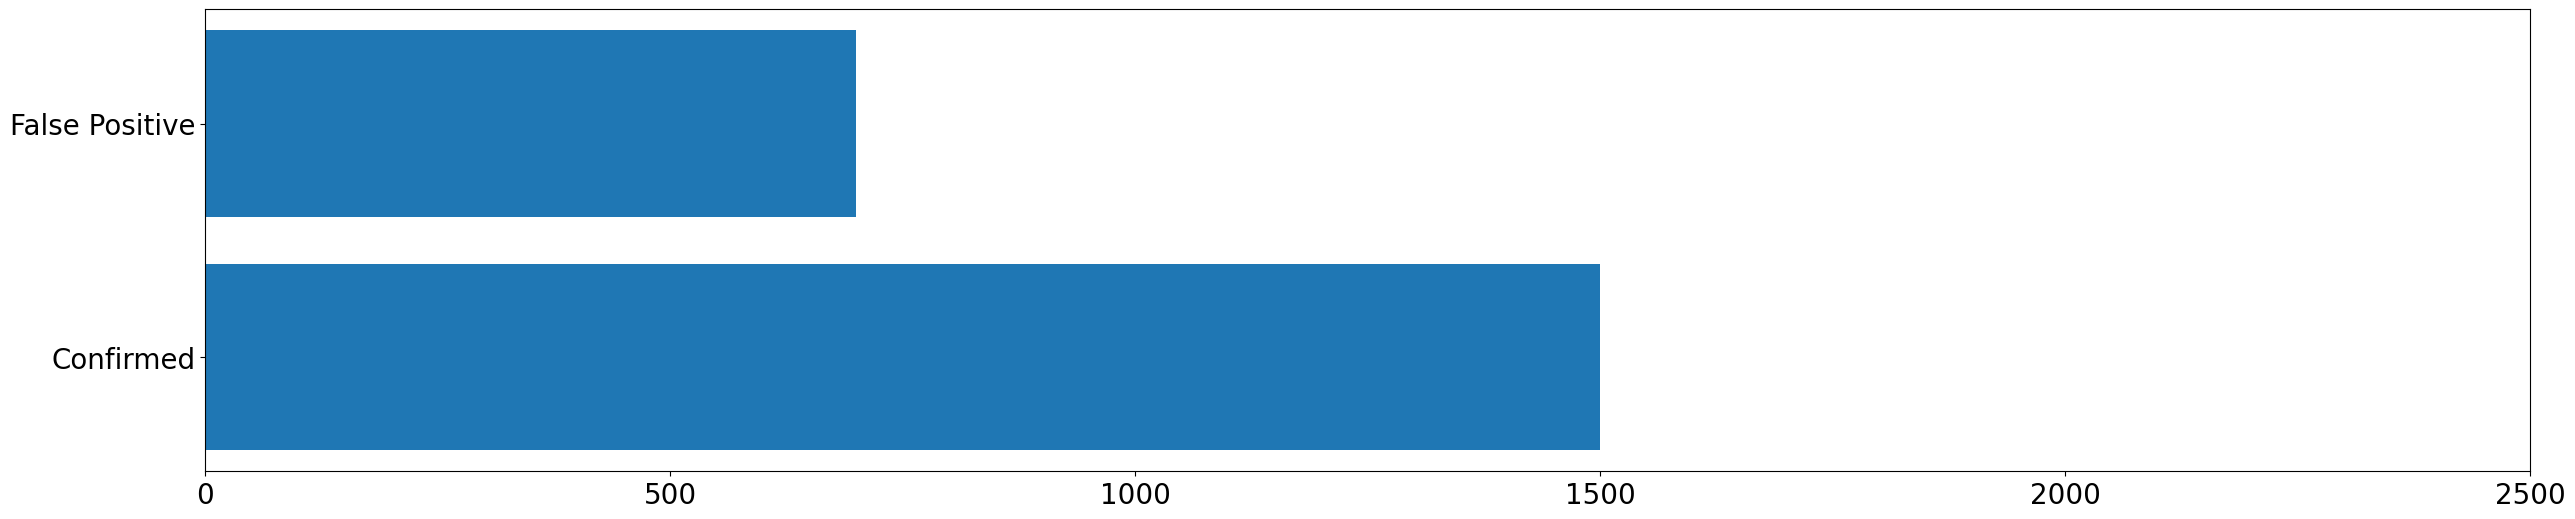

In [10]:
#now we see only about 50% more
fig, ax = plt.subplots()
ax.barh([0,1], [data_conf_resamp['koi_disposition'].value_counts()[1],data_conf_resamp['koi_disposition'].value_counts()[0]], align='center')
ax.set_yticks(ticks=[0,1], labels=['Confirmed', 'False Positive'])
ax.set_xlim(0,2500)

In [11]:
#break up the data into sets to test; we'll also define the x & y values from these

#use the data with stellar + planetary qualities included 
basic_stellar = data_conf_resamp[['koi_disposition', 'koi_model_snr', 'koi_period', 'koi_time0', 'koi_eccen', 'koi_impact',
                   'koi_duration','koi_prad', 'koi_sma', 'koi_incl', 'koi_teq', 'ra', 'dec', 'koi_kepmag',
                    'koi_depth', 'koi_ror', 'koi_dor', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass']]
X_basic_stellar = basic_stellar.drop('koi_disposition', axis=1)
Y_basic_stellar = basic_stellar['koi_disposition']


#then let's see how much accuracy we lose when we don't consider any of the stellar properties
basic = data_conf_resamp[['koi_disposition', 'koi_model_snr', 'koi_period', 'koi_time0', 'koi_eccen', 'koi_impact',
                   'koi_duration','koi_prad', 'koi_sma', 'koi_incl', 'koi_teq', 'ra', 'dec', 'koi_kepmag']]
X_basic = basic.drop('koi_disposition', axis=1)
Y_basic = basic['koi_disposition']



In [12]:
#let's looks at the data 
corr = basic_stellar.corr()
corr.style.background_gradient(cmap='coolwarm')

/opt/anaconda3/envs/ds/lib/python3.9/site-packages/pandas/io/formats/style.py:3925: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/opt/anaconda3/envs/ds/lib/python3.9/site-packages/pandas/io/formats/style.py:3926: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,koi_disposition,koi_model_snr,koi_period,koi_time0,koi_eccen,koi_impact,koi_duration,koi_prad,koi_sma,koi_incl,koi_teq,ra,dec,koi_kepmag,koi_depth,koi_ror,koi_dor,koi_steff,koi_slogg,koi_srad,koi_smass
koi_disposition,1.000000,-0.072814,0.099799,-0.007316,nan,0.143542,0.044273,-0.233950,0.156907,0.251461,-0.384419,-0.221933,0.127933,-0.035704,-0.195451,-0.236249,0.165246,-0.062375,0.044777,-0.053122,-0.083992
koi_model_snr,-0.072814,1.000000,-0.034807,0.052147,nan,-0.094798,0.029490,0.359939,-0.045802,-0.035908,0.138472,0.004988,0.046137,-0.106590,0.563242,0.343315,-0.046656,0.100387,-0.082505,0.059100,0.135775
koi_period,0.099799,-0.034807,1.000000,0.297774,nan,0.070334,0.663572,0.026319,0.969089,0.197244,-0.458104,-0.048636,0.076612,-0.063312,0.001952,0.020670,0.760517,0.093071,-0.069306,0.033420,0.084549
koi_time0,-0.007316,0.052147,0.297774,1.000000,nan,0.030456,0.213458,0.073580,0.305688,0.078869,-0.245455,-0.015804,-0.028758,0.088528,0.108829,0.103911,0.254392,-0.057560,0.034979,-0.027247,-0.005384
koi_eccen,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
koi_impact,0.143542,-0.094798,0.070334,0.030456,nan,1.000000,-0.019513,0.270970,0.087105,-0.458759,-0.103609,-0.047411,-0.058206,-0.020812,0.041754,0.289061,-0.068965,-0.019458,-0.052384,0.022148,0.003638
koi_duration,0.044273,0.029490,0.663572,0.213458,nan,-0.019513,1.000000,0.049276,0.706833,0.136467,-0.382441,0.022248,0.057760,-0.154249,0.015442,-0.008955,0.324315,0.190715,-0.258522,0.168249,0.244294
koi_prad,-0.233950,0.359939,0.026319,0.073580,nan,0.270970,0.049276,1.000000,0.021718,-0.376757,0.163135,0.049151,-0.081030,0.020769,0.489068,0.897293,0.000694,0.042457,-0.195821,0.188440,0.152932
koi_sma,0.156907,-0.045802,0.969089,0.305688,nan,0.087105,0.706833,0.021718,1.000000,0.255966,-0.556188,-0.065413,0.079267,-0.084709,-0.006287,0.007571,0.794857,0.152490,-0.112227,0.061796,0.150047
koi_incl,0.251461,-0.035908,0.197244,0.078869,nan,-0.458759,0.136467,-0.376757,0.255966,1.000000,-0.472949,-0.078708,0.089205,0.031678,-0.040529,-0.297193,0.298921,-0.023153,0.140467,-0.090655,-0.073478


In [13]:
#let's looks at the data 
corr = basic.corr()
corr.style.background_gradient(cmap='coolwarm')

,koi_disposition,koi_model_snr,koi_period,koi_time0,koi_eccen,koi_impact,koi_duration,koi_prad,koi_sma,koi_incl,koi_teq,ra,dec,koi_kepmag
koi_disposition,1.000000,-0.072814,0.099799,-0.007316,nan,0.143542,0.044273,-0.233950,0.156907,0.251461,-0.384419,-0.221933,0.127933,-0.035704
koi_model_snr,-0.072814,1.000000,-0.034807,0.052147,nan,-0.094798,0.029490,0.359939,-0.045802,-0.035908,0.138472,0.004988,0.046137,-0.106590
koi_period,0.099799,-0.034807,1.000000,0.297774,nan,0.070334,0.663572,0.026319,0.969089,0.197244,-0.458104,-0.048636,0.076612,-0.063312
koi_time0,-0.007316,0.052147,0.297774,1.000000,nan,0.030456,0.213458,0.073580,0.305688,0.078869,-0.245455,-0.015804,-0.028758,0.088528
koi_eccen,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
koi_impact,0.143542,-0.094798,0.070334,0.030456,nan,1.000000,-0.019513,0.270970,0.087105,-0.458759,-0.103609,-0.047411,-0.058206,-0.020812
koi_duration,0.044273,0.029490,0.663572,0.213458,nan,-0.019513,1.000000,0.049276,0.706833,0.136467,-0.382441,0.022248,0.057760,-0.154249
koi_prad,-0.233950,0.359939,0.026319,0.073580,nan,0.270970,0.049276,1.000000,0.021718,-0.376757,0.163135,0.049151,-0.081030,0.020769
koi_sma,0.156907,-0.045802,0.969089,0.305688,nan,0.087105,0.706833,0.021718,1.000000,0.255966,-0.556188,-0.065413,0.079267,-0.084709
koi_incl,0.251461,-0.035908,0.197244,0.078869,nan,-0.458759,0.136467,-0.376757,0.255966,1.000000,-0.472949,-0.078708,0.089205,0.031678


In [14]:
#since all the columns are different units/magnitudes we will scale 
scaler = StandardScaler()
X_basic_scaled = scaler.fit_transform(X_basic)
X_basic_stellar_scaled = scaler.fit_transform(X_basic_stellar)

### Let's try the dataset with stellar info

In [116]:
X_train, X_test, Y_train, Y_test = train_test_split(X_basic_stellar_scaled, Y_basic_stellar, train_size=0.7, test_size=0.3, stratify=Y_basic_stellar)

In [117]:
model_stellar = RandomForestClassifier()
history = model_stellar.fit(X_train, Y_train)
Y_pred = model_stellar.predict(X_test)

In [118]:
scores = cross_val_score(model, X_train, Y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.03)


              precision    recall  f1-score   support

           0       0.93      0.85      0.89       210
           1       0.93      0.97      0.95       450

    accuracy                           0.93       660
   macro avg       0.93      0.91      0.92       660
weighted avg       0.93      0.93      0.93       660



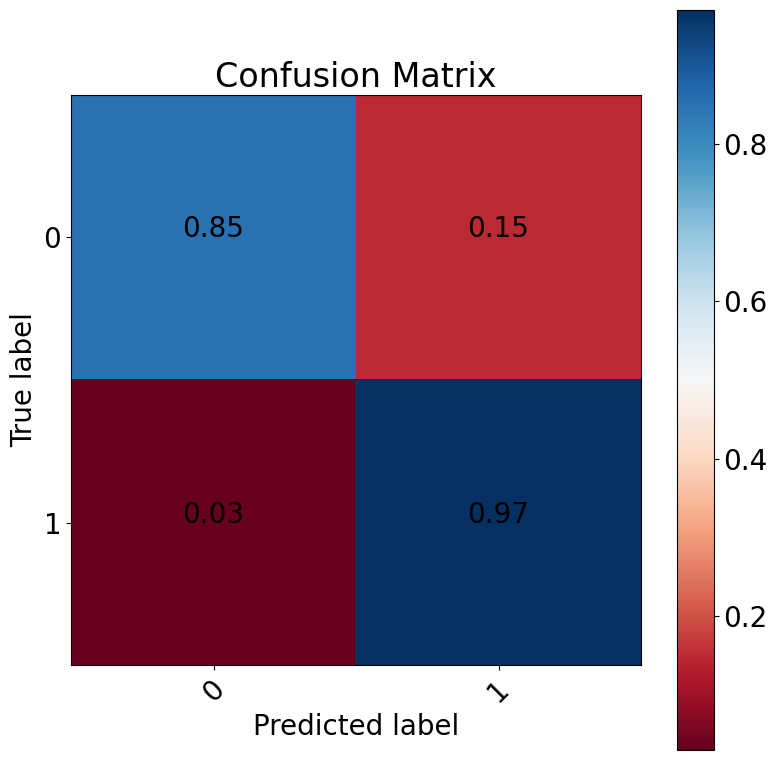

In [119]:
cnf_matrix = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

print(classification_report(Y_test, Y_pred))
# 
# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion Matrix')
plt.show()

### Let's see if using only planetary data has any affect on accuracy

In [109]:
X_train, X_test, Y_train, Y_test = train_test_split(X_basic_scaled, Y_basic, train_size=0.7, test_size=0.3, stratify=Y_basic)

In [110]:
model = RandomForestClassifier()
history = model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [111]:
scores = cross_val_score(model, X_train, Y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.02)


              precision    recall  f1-score   support

           0       0.91      0.80      0.85       210
           1       0.91      0.96      0.94       450

    accuracy                           0.91       660
   macro avg       0.91      0.88      0.89       660
weighted avg       0.91      0.91      0.91       660



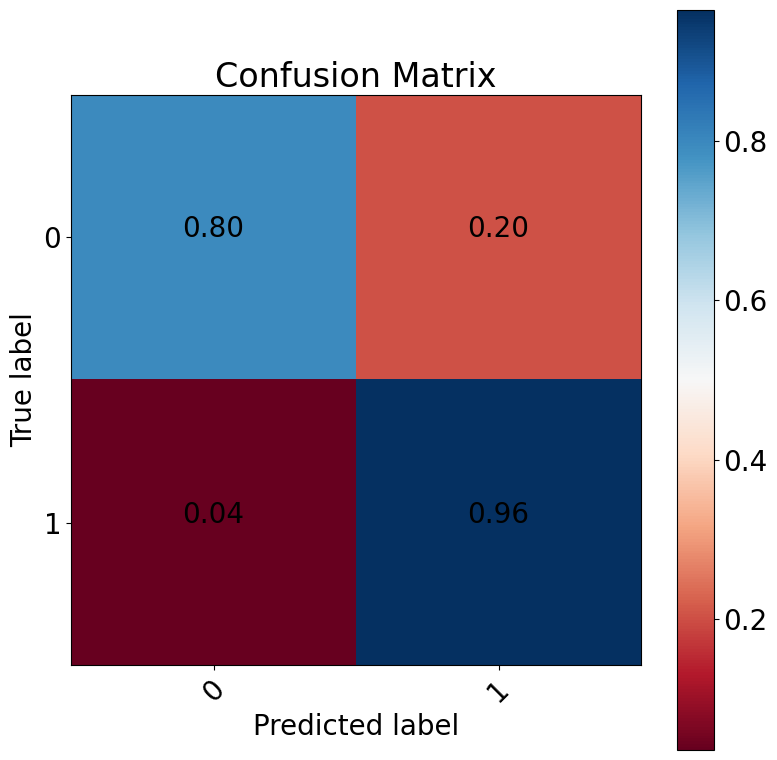

In [112]:
cnf_matrix = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

print(classification_report(Y_test, Y_pred))
# 
# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion Matrix')
plt.show()

## let's circle back to those candidate planets!


In [113]:
basic_candidates = data_cand[['koi_disposition', 'koi_model_snr', 'koi_period', 'koi_time0', 'koi_eccen', 'koi_impact',
                   'koi_duration','koi_prad', 'koi_sma', 'koi_incl', 'koi_teq', 'ra', 'dec', 'koi_kepmag',
                    'koi_depth', 'koi_ror', 'koi_dor', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass']]
X_candidates = basic_candidates.drop('koi_disposition', axis=1)

In [114]:
#since all the columns are different units/magnitudes we will scale 
scaler = StandardScaler()
X_candidates_scaled = scaler.fit_transform(X_candidates)

In [121]:
Y_candidates = pd.DataFrame(model_stellar.predict(X_candidates_scaled))

([<matplotlib.patches.Wedge at 0x7fecb7678c40>,
 [Text(-0.7430176878966906, 0.8111255855122905, 'Maybe Not Exoplanet'),
  Text(0.7430176878966905, -0.8111255855122905, 'Maybe Exoplanet')])

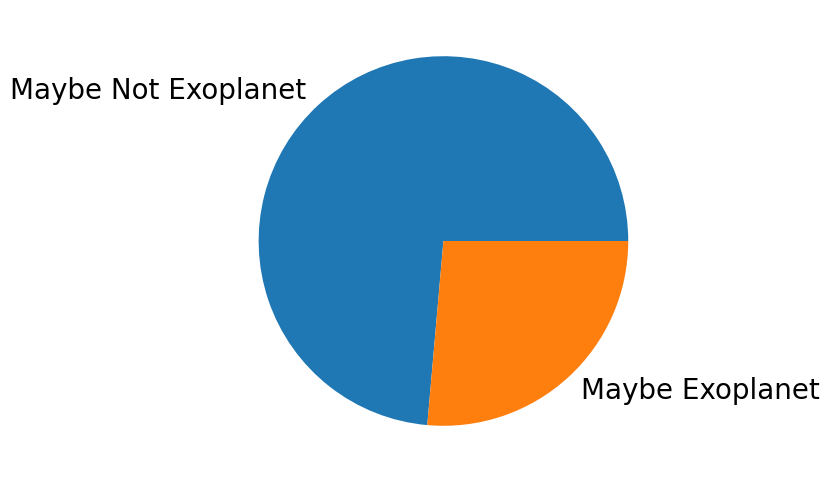

In [130]:
count = [Y_candidates.value_counts()[0], Y_candidates.value_counts()[1]]
labels = ['Maybe Not Exoplanet', 'Maybe Exoplanet']
plt.pie(count, labels=labels)

## Let's do deep learning for fun

In [65]:
#Normalizing features with MinMax Scaler
min_max_scaler = preprocessing.MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X_basic)

In [66]:
X_train, X_test, Y_train, Y_test = train_test_split(X_minmax, Y_basic, train_size=0.7, test_size=0.3, stratify=Y_basic)

In [71]:
inputs = keras.Input(shape=(13, ), name='input_layer')


## First hidden layer
l_1 = layers.Dense(126, activation='relu',name='l_1')(inputs)
l_1 = layers.BatchNormalization()(l_1)
l_1 = layers.Dropout(0.2)(l_1)

## Second hidden layer
l_2 = layers.Dense(126, activation='relu',name='l_2')(l_1)
l_2 = layers.BatchNormalization()(l_2)


## output layer
outputs = layers.Dense(1, activation='sigmoid',name='output_layer')(l_2)
                       

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 13)]              0         
                                                                 
 l_1 (Dense)                 (None, 126)               1764      
                                                                 
 batch_normalization_8 (Batc  (None, 126)              504       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 126)               0         
                                                                 
 l_2 (Dense)                 (None, 126)               16002     
                                                                 
 batch_normalization_9 (Batc  (None, 126)              504       
 hNormalization)                                           

In [92]:
model.compile(
    optimizer='adam',
    loss='mae',
    metrics=['accuracy'])

In [93]:
history= model.fit(X_train, Y_train, epochs=100, validation_split=0.2, batch_size=100)

Epoch 1/100


/opt/anaconda3/envs/ds/lib/python3.9/site-packages/keras/engine/data_adapter.py:1508: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


13/13 [==============================] - 0s 9ms/step - loss: 0.1645 - accuracy: 0.8409 - val_loss: 0.2645 - val_accuracy: 0.7273
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1571 - accuracy: 0.8498 - val_loss: 0.2613 - val_accuracy: 0.7305
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1531 - accuracy: 0.8531 - val_loss: 0.2516 - val_accuracy: 0.7468
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1536 - accuracy: 0.8506 - val_loss: 0.2420 - val_accuracy: 0.7565
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1533 - accuracy: 0.8506 - val_loss: 0.2389 - val_accuracy: 0.7662
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1482 - accuracy: 0.8571 - val_loss: 0.2389 - val_accuracy: 0.7662
Epoch 7/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1488 - accuracy: 0.8588 - val_loss: 0.2281 - val_accuracy: 0.7760
Epoch 8/100
13/13 [======

Accuracy: 84.24%


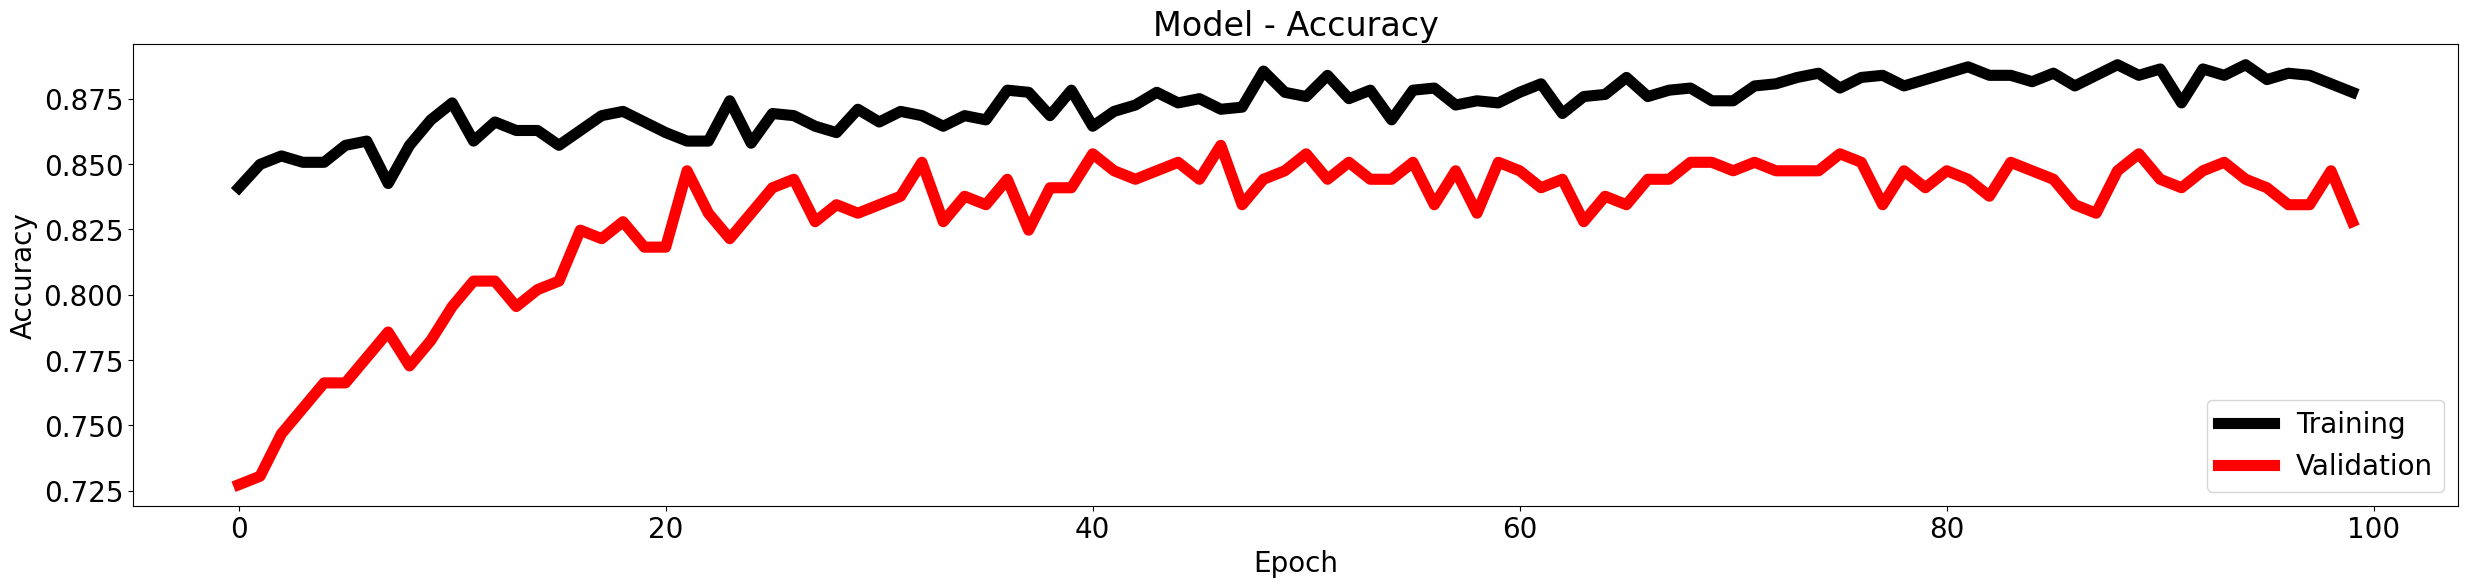

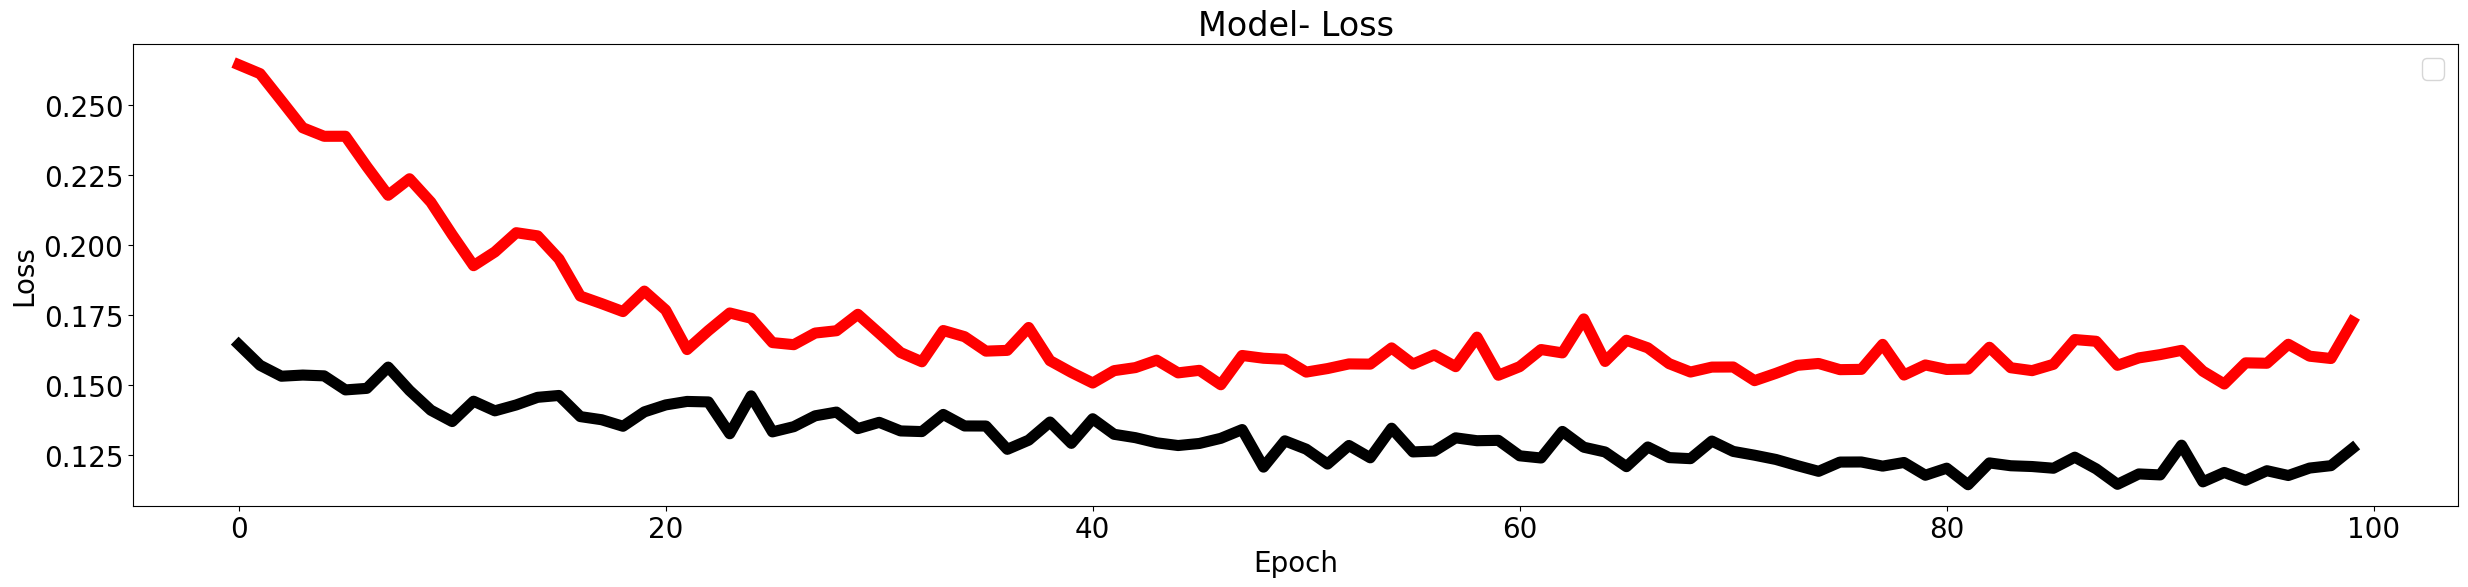

21/21 [==============================] - 0s 652us/step


In [94]:
evaluate_model(history,X_test,Y_test,model)

21/21 [==============================] - 0s 577us/step
              precision    recall  f1-score   support

           0       0.63      0.75      0.68       210
           1       0.87      0.80      0.83       450

    accuracy                           0.78       660
   macro avg       0.75      0.77      0.76       660
weighted avg       0.79      0.78      0.78       660



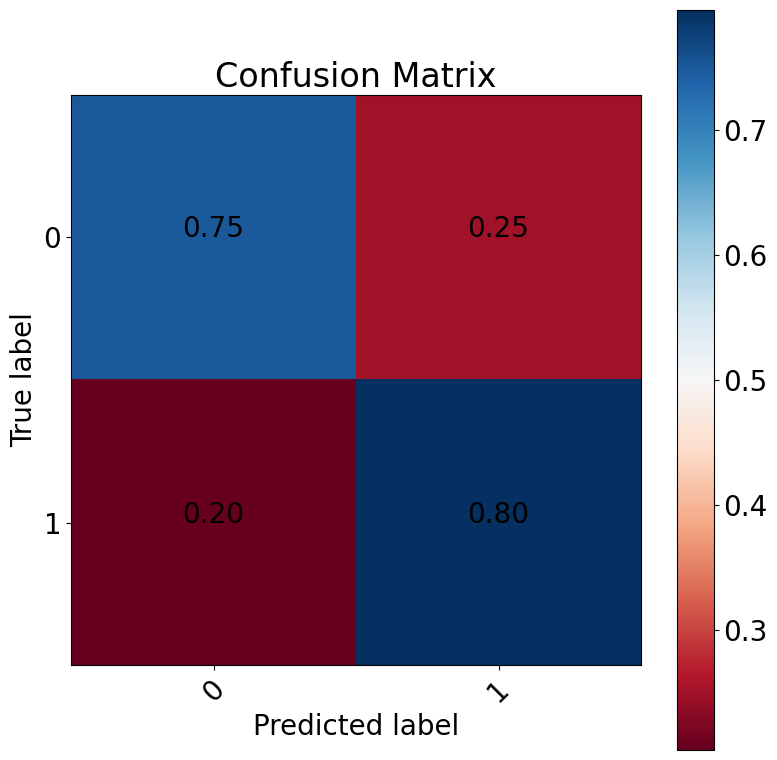

In [104]:
Y_pred = model.predict(X_test)
Y_pred = np.where(Y_pred < 0.9985, 0, 1)
cnf_matrix = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

print(classification_report(Y_test, Y_pred))
# 
# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion Matrix')
plt.show()